# 事前準備：共通コードの実行
* このノートブックに接続したら，まずは以下の2つの共通コード（コードAとコードB）を実行する
* これらの共通コードを実行しないと，それ以降のコードが実行できないので注意する
* また，コードAとコードBは，ノートブックに接続するたび毎回実行すること（ノートブックに接続中は，何度も実行する必要はない）
* 共通コードの詳細についての説明は割愛する（簡単な説明は第2回の「[サンプルノートブック02](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook02.ipynb)」を参照）

In [1]:
# コードA：日本語化ライブラリ導入
! pip install japanize-matplotlib | tail -n 1

In [2]:
# コードB：共通事前処理

# B1:余分なワーニングを非表示にする
import warnings
warnings.filterwarnings('ignore')

# 必要ライブラリのimport
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib # matplotlib日本語化対応
import seaborn as sns

# B2:データフレーム表示用関数
from IPython.display import display

# B3:表示オプション調整
np.set_printoptions(suppress = True, precision = 3) #numpyの浮動小数点の表示精度
pd.options.display.float_format = '{:.3f}'.format #pandasでの浮動小数点の表示精度
pd.set_option('display.max_columns', None) #データフレームですべての列データを表示

# B4:グラフのデフォルトフォント指定
plt.rcParams['font.size'] = 14

# 乱数の種
random_seed = 0

# マハラノビス距離を用いた外れ値の処理

## 外れ値の影響
* 外れ値とは，他のデータの値と比べて大きく離れている値のこと
* 外れ値が及ぼす影響
>* モデルの性能を低下させる可能性がある
>* 標準化が適切に行われない
>* 可視化のために作成したグラフ等の図の解釈が難しくなる
* このような影響を取り除くため，学習前に外れ値があるか確認する必要がある
* 一般には，外れ値は削除する

## 単純な外れ値の処理
* データの中心（算術平均）から極端に離れているものを外れ値とみなす
* 1次元データ: データを小さい順（or 大きい順）に並べて，極端に離れているデータを見つける
* 2次元データ: 散布図を作成して視覚的（主観的）に外れ値を見つける
* 多次元データ: 2変数間の散布図を複数作成し，2次元データと同様にして外れ値を見つける
* 特徴量（次元）が少ない場合には，散布図を描いて，目視で外れ値を確認する方法で問題はないが，特徴量の数が膨大になると目視による確認は困難となる
* また，この方法だと，分析者の主観が入ってしまうことも問題となる
* ここでは，分析者の主観に依存しない外れ値の処理を考える

## データの読み込み
* 例として以下のURLのデータを使う
>* https://bit.ly/4iLNUpS
* このデータは，外れ値の処理を行うために作成した2次元の人工データ（数値に意味はない）
  
**［以下のコードの処理内容］**
*  1行目: ファイルのURLを変数`url`に代入
*  2行目: pandasの`read_csv`関数を使って，ファイルをDataFrameとして読み込んで，変数`df`に代入
*  3行目: `display`関数を使ってデータ（`df`の内容）を表示

In [ ]:
url = 'https://bit.ly/4iLNUpS'
df = pd.read_csv(url)
display(df)

,x,y
0,0.351,0.546
1,0.042,-0.350
2,1.398,0.845
3,0.728,0.038
4,0.462,0.571
5,-0.596,-0.474
6,-0.304,-1.145
7,-1.485,-2.033
8,1.189,1.752
9,-0.443,-1.235


## 統計量の計算
* 読み込んだ人工データに対して，`describe`メソッドを用いて代表的な統計量を計算する
  
**［以下のコードの処理内容］**
*  1～2行目: データを読み込んで，変数`df`に代入
*  3行目: `discribe`メソッドで代表的な統計量を計算し，その結果を`display`関数で表示

In [ ]:
url = 'https://bit.ly/4iLNUpS'
df = pd.read_csv(url)
display(df.describe())

,x,y
count,53.000,53.000
mean,0.115,0.046
std,1.080,1.187
min,-2.801,-2.901
25%,-0.521,-0.699
50%,0.042,0.164
75%,0.579,0.724
max,2.781,3.074


## 散布図の作成
* 人工データの散布図を作成する
* 散布図上には，$x$と$y$の算術平均（破線）も描画する
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3行目: `mean`メソッドで x列（`df['x']`）の算術平均を計算し，その結果を`x_mean`に代入
* 4行目: `mean`メソッドで y列（`df['y']`）の算術平均を計算し，その結果を`y_mean`に代入
* 5行目: `scatter`関数を使って x列（`df['x']`）と y列（`df['y']`）の散布図を作成
* 6行目: `plt.tick_params(labelbottom = False, labelleft = False)`で，縦軸と横軸のラベル（数値）を非表示にする
* 7行目: `axvline`関数を使って，x軸が`x_mean` の位置（`x = x_mean`）に緑（`color = 'green'`）の破線（`linestyle='--'`）で垂直線を描画
>* `label = 'xの算術平均'`で，凡例に表示するラベルを設定
* 7行目: `axhline`関数を使って，y軸が`y_mean` の位置（`y = y_mean`）に赤（`color = 'red'`）の破線（`linestyle='--'`）で水平線を描画
>* `label = 'yの算術平均'`で，凡例に表示するラベルを設定
* 8行目: `legend`関数で凡例を表示
* 9行目: `show`関数で，それまでに設定した図（散布図）を実行画面に表示

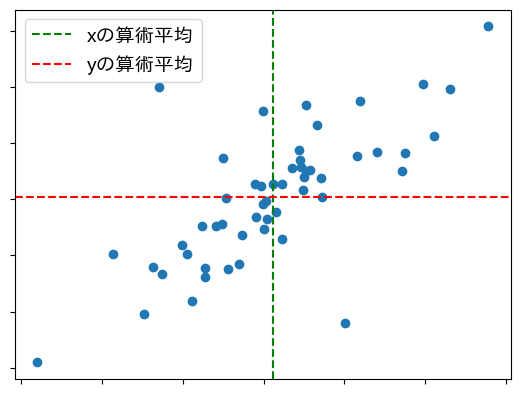

In [ ]:
url = 'https://bit.ly/4iLNUpS'
df = pd.read_csv(url)
x_mean = df['x'].mean()
y_mean = df['y'].mean()
plt.scatter(df['x'], df['y'])
plt.tick_params(labelbottom = False, labelleft = False)
plt.axvline(x = x_mean, color = 'green', linestyle='--', label = 'xの算術平均')
plt.axhline(y = y_mean, color = 'red', linestyle='--', label = 'yの算術平均')
plt.legend()
plt.show()

## 算術平均（重心）からの距離による主観的な外れ値の判定
* 散布図上の点$(\bar{x}, \bar{y})$は，データの重心になる
* この重心から$(\pm 2, \pm 2)$離れた点を外れ値とすれば，目視による判定よりも客観性があるといえる
* 以下のコードでは，上記基準で外れ値と判定されたデータを散布図上で赤い点にしている
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～9行目: 1つ前のコードと同様の散布図を作成
* 10行目: `df`に対して，重心から$(+2, +2)$離れた点（データ）を検索し，その結果を`df_out1`に代入
>* 検索条件: `(df['x'] > x_mean + 2) & (df['y'] > y_mean + 2)`
* 11行目: `df`に対して，重心から$(-2, +2)$離れた点（データ）を検索し，その結果を`df_out2`に代入
>* 検索条件: `(df['x'] < x_mean - 2) & (df['y'] > y_mean + 2)`
* 12行目: `df`に対して，重心から$(-2, -2)$離れた点（データ）を検索し，その結果を`df_out3`に代入
>* 検索条件: `(df['x'] < x_mean - 2) & (df['y'] < y_mean - 2)`
* 13行目: `df`に対して，重心から$(+2, -2)$離れた点（データ）を検索し，その結果を`df_out4`に代入
>* 検索条件: `(df['x'] > x_mean + 2) & (df['y'] < y_mean - 2)`
* 14行目: `concat`関数を使って，検索結果である 4つのDataFrame `df_out1`から`df_out4`を結合し，変数`df_out`に代入
* 15行目: `scatter`関数を使って 外れ値 `df_out` の x列（`df_out['x']`）と y列（`df_out['y']`）の散布図を作成
>* 1つ目の散布図の上に重ねて描かれる
* 16行目: `show`関数で，それまでに設定した図（2つ散布図が重なった図）を実行画面に表示

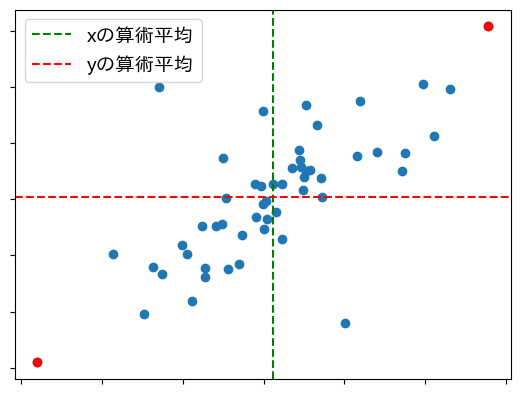

In [ ]:
url = 'https://bit.ly/4iLNUpS'
df = pd.read_csv(url)
x_mean = df['x'].mean()
y_mean = df['y'].mean()
plt.scatter(df['x'], df['y'])
plt.tick_params(labelbottom = False, labelleft = False)
plt.axvline(x = x_mean, color = 'green', linestyle='--', label = 'xの算術平均')
plt.axhline(y = y_mean, color = 'red', linestyle='--', label = 'yの算術平均')
plt.legend()
df_out1 = df[(df['x'] > x_mean + 2) & (df['y'] > y_mean + 2)]
df_out2 = df[(df['x'] < x_mean - 2) & (df['y'] > y_mean + 2)]
df_out3 = df[(df['x'] < x_mean - 2) & (df['y'] < y_mean - 2)]
df_out4 = df[(df['x'] > x_mean + 2) & (df['y'] < y_mean - 2)]
df_out = pd.concat([df_out1, df_out2, df_out3, df_out4], axis = 1)
plt.scatter(df_out['x'],df_out['y'], color='red')
plt.show()

* 2次元データが無相関で円状にばらついた場合なら，算術平均（重心）からの距離で外れ値を判定してもよさそうだが...
* この例のように相関のある2次元データの場合や，各変数間でのばらつきに違いがある場合には，重心からの距離で判定することは一般にはできない
* 実際，上の散布図において，左上や右下に位置するデータを外れ値と判定したほうがよさそうにも見える

## マハラノビス距離による外れ値の判定
* 上の例からわかるように，重心からの単純な距離では，データの相関やばらつき（データの分布）などが考慮できていない
* 次に，データの分布を考慮した距離である「**マハラノビス距離**」を用いて外れ値を判定することを考える
* マハラノビス距離の詳細については省略するので，興味があれば機械学習関連の書籍等を参照すること

### マハラノビス距離による外れ値判定手順
* 各データに対してマハラノビス距離をそれぞれ計算
* 求めたマハラノビス距離から四分位範囲を計算
* 四分位範囲をもとに上限値と下限値を定める
* マハラノビス距離が上限値を上回るデータと下限値を下回るデータを外れ値として判定する

#### 四分位範囲
* 四分位範囲（IQR: interquartile range）は，第1四分位数と第2四分位数の差として定義される
* `四分位範囲 IQR = 第3四分位数 － 第1四分位数`
* この定義より，四分位範囲の中に全データの50％が必ず収まることになる．  


#### 外れ値の判定基準
* 四分位範囲に基づいて，外れ値の判定基準が定められる
>* `上限値 = 第3四分位数 ＋ 1.5 × IQR`
>* `下限値 = 第1四分位数 － 1.5 × IQR`
* 上限値を上回る，または下限値を下回るデータを外れ値として判定する

### マハラノビス距離の計算
* Pythonでマハラノビス距離を計算する方法の一つにscikit-learnの`cobariance`モジュールにおける，`MinCovDet`クラスの利用がある
>* `MinCovDet`の意味: Minimum Covariance Determinant（MCD）
* この方法では，乱数を利用するため乱数の種（randam_seed）を指定する
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3行目: `sklearn` (scikit-learn) の`covariance`モジュール内にある`MinCovDet`クラスを読み込む
* 4行目: `MinCovDet`クラスのオブジェクトを生成し，変数`mcd`に代入
>* 乱数の種を `random_state = random_seed` で指定
* 5～6行目: 生成したオブジェクトに対して，`fit`メソッドと`mahalanobis`メソッドを順番に呼び出し，マハラノビス距離を計算
>* いずれのメソッドの引数にも `df`を指定
>* 計算結果を変数`distance`に代入
>* `distance`のクラス（データ型）は `ndarray`
* 7行目: `DataFrame`関数で，`distance`をDataFrameに変換
* 8行目: `concat`関数で，2つのDataFrame `df`と`distance` を結合し，その結果を`df`に代入
* 9行目: `display`関数で，`df`を表示

In [ ]:
url = 'https://bit.ly/4iLNUpS'
df = pd.read_csv(url)
from sklearn.covariance import MinCovDet
mcd = MinCovDet(random_state = random_seed)
mcd.fit(df)
distance = mcd.mahalanobis(df)
distance = pd.DataFrame(distance, columns = ['マハラノビス距離'])
df = pd.concat([df, distance], axis=1)
display(df)

,x,y,マハラノビス距離
0,0.351,0.546,0.475
1,0.042,-0.350,0.315
2,1.398,0.845,2.057
3,0.728,0.038,1.271
4,0.462,0.571,0.388
5,-0.596,-0.474,0.670
6,-0.304,-1.145,2.471
7,-1.485,-2.033,4.583
8,1.189,1.752,3.755
9,-0.443,-1.235,2.468


### 箱ひげ図の作成
* 各データのマハラノビス距離の分布を確認するために箱ひげ図を作成する
* 箱ひげ図の作成方法は，第2回の「[サンプルノートブック02](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook02.ipynb)」を参照する
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～8行目: マハラノビス距離を計算し，結果を`df`に統合
* 9行目: `boxplot`関数で，マハラノビス距離（`df['マハラノビス距離']`）の箱ひげ図を作成
* 10行目: `xticks`関数で，x軸のラベルを「マハラノビス距離」に設定
* 11行目: `show`関数で，それまでに設定した図（箱ひげ図）を実行画面に表示

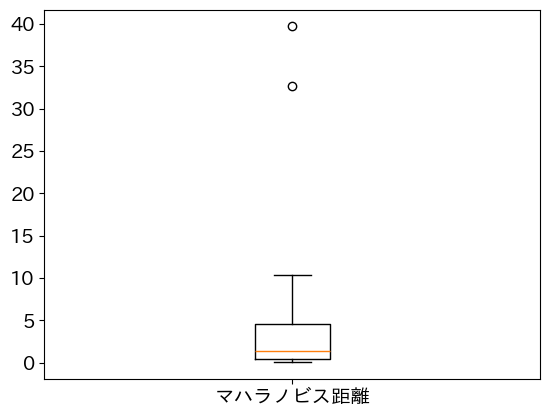

In [ ]:
url = 'https://bit.ly/4iLNUpS'
df = pd.read_csv(url)
from sklearn.covariance import MinCovDet
mcd = MinCovDet(random_state = random_seed)
mcd.fit(df)
distance = mcd.mahalanobis(df)
distance = pd.DataFrame(distance, columns = ['マハラノビス距離'])
df = pd.concat([df, distance], axis=1)
plt.boxplot(df['マハラノビス距離'])
plt.xticks([1], ['マハラノビス距離'])
plt.show()

### 四分位範囲による外れ値の判定基準
* 前述のように，四分位範囲（`IQR`）に基づいて，外れ値の判定基準が定められる
>* `IQR = 第3四分位数 － 第1四分位数`
* 四分位数は，DataFrameの`quantile`メソッドで計算できる
>* 第1四分位数: `df.quantile(0.25)`
>* 第3四分位数: `df.quantile(0.75)`
* 以下の上限値を上回る，または下限値を下回るデータを外れ値として判定．
>*  `上限値 = 第3四分位数 ＋ 1.5 × IQR`
>*  `下限値 = 第1四分位数 － 1.5 × IQR`
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～8行目: マハラノビス距離を計算し，結果を`df`に統合
* 9行目: `quantile`メソッドで，マハラノビス距離（`df['マハラノビス距離']`）の第1四分位数を計算し，変数`q1`に代入
* 10行目: `quantile`メソッドで，マハラノビス距離（`df['マハラノビス距離']`）の第3四分位数を計算し，変数`q3`に代入
* 11行目: `q3 - q1`で IQRを計算し，変数`iqr`に代入
* 12行目: 判定基準の上限値を計算し，変数`upper`に代入
* 13行目: 判定基準の下限値を計算し，変数`lower`に代入
* 14行目: `df`から，判定基準を満たすデータを検索し，結果を変数`df_out`に代入
* 15行目: `display`関数で，外れ値 `df_out` を表示
* 16～22行目: 散布図を作成（外れ値を赤でプロット）

,x,y,マハラノビス距離
12,-1.301,2.001,39.691
43,1.001,-2.201,32.645


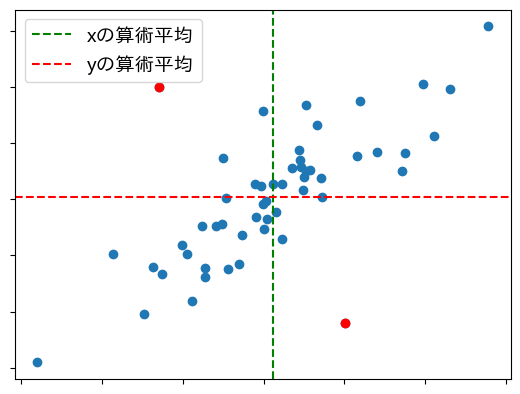

In [ ]:
url = 'https://bit.ly/4iLNUpS'
df = pd.read_csv(url)
from sklearn.covariance import MinCovDet
mcd = MinCovDet(random_state = random_seed)
mcd.fit(df)
distance = mcd.mahalanobis(df)
distance = pd.DataFrame(distance, columns = ['マハラノビス距離'])
df = pd.concat([df, distance], axis=1)
q1 = df['マハラノビス距離'].quantile(0.25)
q3 = df['マハラノビス距離'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
df_out = df[(df['マハラノビス距離'] > upper) | (df['マハラノビス距離'] < lower)]
display(df_out)
plt.scatter(df['x'], df['y'])
plt.tick_params(labelbottom = False, labelleft = False)
plt.axvline(x = x_mean, color = 'green', linestyle='--', label = 'xの算術平均')
plt.axhline(y = y_mean, color = 'red', linestyle='--', label = 'yの算術平均')
plt.legend()
plt.scatter(df_out['x'],df_out['y'], color='red')
plt.show()

# 時系列データに対する欠損値の処理

## データの読み込み
* 時系列データとは，時間の経過順に並んだデータのこと
* 過去のデータが未来のデータに影響を与えるという特徴がある
* ここでは，以下の人工時系列データを用いて，時系列データに対する欠損値の処理方法について考える
* 人工時系列データ: https://bit.ly/4kw4Fr2
  
**［以下のコードの処理内容］**
*  1行目: ファイルのURLを変数`url`に代入
*  2行目: pandasの`read_csv`関数を使って，ファイルをDataFrameとして読み込んで，変数`df`に代入
*  3行目: `display`関数を使ってデータ（`df`の内容）を表示

In [ ]:
url = 'https://bit.ly/4kw4Fr2'
df = pd.read_csv(url)
display(df)

,Date,Value
0,2023/1/1,1.764
1,2023/1/2,2.164
2,2023/1/3,3.143
3,2023/1/4,5.384
4,2023/1/5,7.251
5,2023/1/6,NaN
6,2023/1/7,7.224
7,2023/1/8,7.073
8,2023/1/9,6.970
9,2023/1/10,7.380


## 欠損値の確認
* まずは，各列で欠損値があるかどうかを確認する
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3行目: `isnull`メソッドと`sum`メソッドを組み合わせて，各列の欠損値の数を計算して，`display`関数で表示する

In [ ]:
url = 'https://bit.ly/4kw4Fr2'
df = pd.read_csv(url)
display(pd.DataFrame(df.isnull().sum(), columns = ['欠損値の数']))

,欠損値の数
Date,0
Value,3


## 欠損値の可視化
* Value列に欠損値があるので，折れ線グラフで可視化する
>* コードは理解しなくても，結果を読み取ることができていればよい
* ここで作成する折れ線グラフの横軸に対して，細かい設定をする必要があるため，`pyplot`モジュールの`sublots`関数を使って，少し複雑なコードを記述する
* `sublots`関数の概要は以下の通り
>* `sublots`関数を呼び出して，`Figure`オブジェクトと`Axes`オブジェクトのタプル（tuple）を生成する
>* `Figure`オブジェクトは図全体を表すオブジェクトで，図の全体的なレイアウトやスタイルを設定するために使用される
>* `Axes`オブジェクトは図が描かれる領域を表すオブジェクトで，データのプロットや，軸の設定を行うために使用される
>* この領域は，単一のプロット領域を表す場合もあれば，複数のプロット領域を含む配列として扱う場合もある
* さらに，日付データを扱えるようにするために，`matplotlib`の`dates`モジュールをインポートする（mdatesで略記）
* 具体的には，`ax.xaxis.set_major_locator(mdates.AutoDateLocator())` と記述することで，横軸に対して日付目盛りを自動的に適切な間隔で配置する
* `mdates.AutoDateLocator` は，日付軸の目盛りの配置を自動的に調整するためのロケーター（locator）と呼ばれるクラスの一つである
* ロケーター（locator）は，`matplotlib` でグラフを作成する際に，軸の目盛りに位置を制御するためのクラスで，用途に合わせて様々なものが用意されている
* `mdates.AutoDateLocator`を利用するためには，`Axes`オブジェクトの`xaxis.set_major_locator` メソッドを使用する
* これにより，横軸（x軸）の主要目盛（major ticks）を自動的に調整できる
* `xaxis`は`Axes`オブジェクトの属性として定義されるオブジェクトで，`set_major_locator`は，`xaxis`オブジェクトに定義されるメソッドとなる
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3行目: `sublots`関数を使って，`Figure`オブジェクトと`Axes`オブジェクトを生成し，変数 `fig` と `ax` にそれぞれ代入
>* `figsize = (8, 4)`で，サイズ指定も同時に行う
* 4行目: `ax`に対する`plot`メソッドを使って，Date（`df['Date']`）とValue（`df['Value']`）の折れ線グラフを作成
* 5行目: `ax`に対する`tick_params`メソッドを使って，x軸ラベル（`axis = 'x'`）を45度回転（`rotation = 45`）
* 6行目: `matplotlib`の`dates`モジュール読み込み（`mdates`で略記）
* 7行目: `ax.xaxis.set_major_locator(mdates.AutoDateLocator())`で，横軸の目盛表示を自動調整
* 8行目: `show`関数で，それまでに設定した図を実行画面に表示

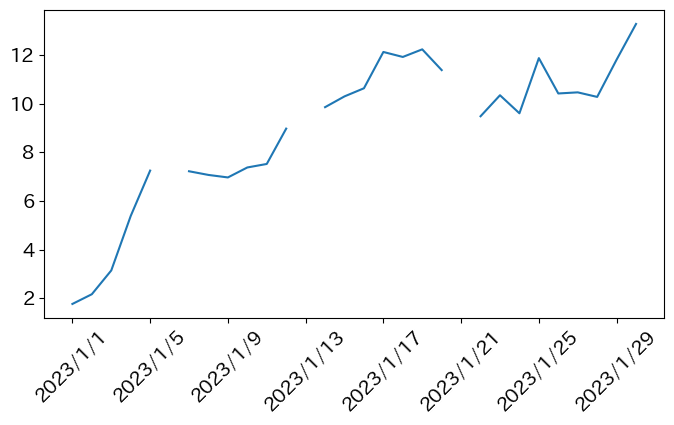

In [ ]:
url = 'https://bit.ly/4kw4Fr2'
df = pd.read_csv(url)
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(df['Date'], df['Value'])
ax.tick_params(axis = 'x', rotation = 45)
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

## 欠損値への対処
* 時系列データは，過去のデータが未来のデータに影響を与えるという特徴があるため，時系列データの欠損値に対しては，欠損値の前後のデータに対して直線を引いて，欠損値の穴埋めをする方法が一般に用いられる
* このような欠損値への対処方法を**線形補間**と呼ぶ
* DataFrameに対する線形補間は`interpolate`メソッドを用いる
* 以下のコードは，1つ前のコードに`interpolate`メソッドによる線形補間の処理のみを追加したコードとなる
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3行目: `interpolate`メソッドで，Value列（`df['Value']`）の欠損値に対して線形補間を施す
* 4行目: `sublots`関数を使って，`Figure`オブジェクトと`Axes`オブジェクトを生成し，変数 `fig` と `ax` にそれぞれ代入
>* `figsize = (8, 4)`で，サイズ指定も同時に行う
* 5行目: `ax`に対する`plot`メソッドを使って，Date（`df['Date']`）とValue（`df['Value']`）の折れ線グラフを作成
* 6行目: `ax`に対する`tick_params`メソッドを使って，x軸ラベル（`axis = 'x'`）を45度回転（`rotation = 45`）
* 7行目: `matplotlib`の`dates`モジュール読み込み（`mdates`で略記）
* 8行目: `ax.xaxis.set_major_locator(mdates.AutoDateLocator())`で，横軸の目盛表示を自動調整
* 9行目: `show`関数で，それまでに設定した図を実行画面に表示

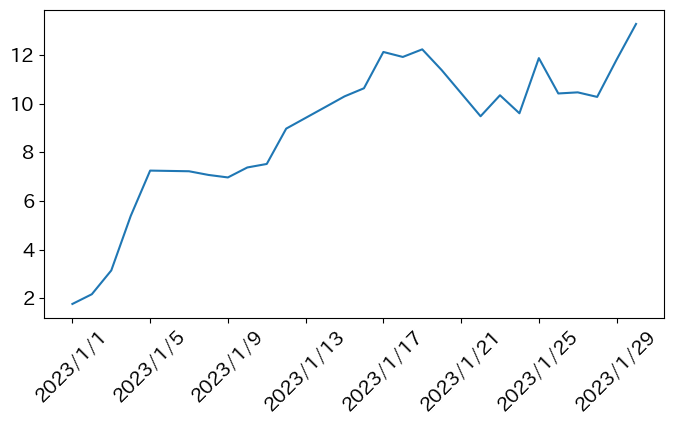

In [ ]:
url = 'https://bit.ly/4kw4Fr2'
df = pd.read_csv(url)
df['Value'] = df['Value'].interpolate()
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(df['Date'], df['Value'])
ax.tick_params(axis = 'x', rotation = 45)
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

# 自転車データに対する時系列データ分析

## 自転車データ
* 時系列データの分析の主たる目的は，過去の目的変数の値をもとに，未来の目的変数の値を予測することである
* ここでは，例として，以下のURLにあるcsvファイルを用いる．
* 自転車データ: https://tinyurl.com/27ypssnc
>* このデータは，米国ワシントンD.C.におけるバイクシェリングに関する2011年から2012年の履歴データ（元データ: http://capitalbikeshare.com/system-data ）．
>* データは日単位で集計され，対応する天候および季節情報が抽出され追加されている（天候情報は http://www.freemeteo.com から抽出）
>* ここで使用する自転車データは，UCI機械学習リポジトリ（https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset ）のデータを加工したものになっている

### 自転車データの読み込み
**［以下のコードの処理内容］**
*  1行目: ファイルのURLを変数`url`に代入
*  2行目: pandasの`read_csv`関数を使って，ファイルをDataFrameとして読み込んで，変数`df`に代入
*  3行目: `display`関数を使ってデータ（`df`の内容）を表示

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
display(df)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011/1/1,1,0,1,0,6,0,2,0.344,0.364,0.806,0.160,331,654,985
1,2011/1/2,1,0,1,0,0,0,2,0.363,0.354,0.696,0.249,131,670,801
2,2011/1/3,1,0,1,0,1,1,1,0.196,0.189,0.437,0.248,120,1229,1349
3,2011/1/4,1,0,1,0,2,1,1,0.200,0.212,0.590,0.160,108,1454,1562
4,2011/1/5,1,0,1,0,3,1,1,0.227,0.229,0.437,0.187,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2012/12/27,1,1,12,0,4,1,2,0.254,0.227,0.653,0.350,247,1867,2114
727,2012/12/28,1,1,12,0,5,1,2,0.253,0.255,0.590,0.155,644,2451,3095
728,2012/12/29,1,1,12,0,6,0,2,0.253,0.242,0.753,0.124,159,1182,1341
729,2012/12/30,1,1,12,0,0,0,1,0.256,0.232,0.483,0.351,364,1432,1796


### データの内容の確認
読み込んだ自転車データの各列名と意味は以下の通り．

|**列名**| **意味** |
|:--|:--|
|dteday | 日付|
|season | 季節 (1: 春, 2: 夏, 3: 秋, 4: 冬) |
|yr | 年 (0: 2011, 1: 2012) |
|mnth | 月 (1～12) |
|holiday| その日が祝日かどうか|
|weekday| 曜日（日曜～土曜: 0～6） |
|workingday| その日が週末でも祝日でもない場合は1，それ以外は0 |
|weathersit| 天気 (1: 晴れ, 2: 曇り, 3: 小雨, 4: 大雨) (※)|
|temp| 摂氏で正規化された気温（値は最大の41で割られている） |
|atemp| 摂氏で正規化された体感気温（値は最大の50で割られている） |
|hum| 正規化された湿度（値は最大の100で割られている） |
|windspeed| 正規化された風速（値は最大の67で割られている）|
|casual| 臨時ユーザー利用数 |
|registered| 登録ユーザー利用数 |
|cnt| 全体ユーザー利用数 |

  
(※) 詳細は以下の通り．
*  1: 晴れ、少し曇り、部分的に曇り
*  2: 霧 + 曇り、霧 + 曇りがち、霧 + 少し曇り、霧
*  3: 小雪、小雨 + 雷雨 + 断続的な曇り、小雨 + 断続的な曇り
*  4: 大雨 + 氷の粒 + 雷雨 + 霧、雪 + 霧


## データの前処理

### 日付データに変換
* dteday列は日付になっているが，`object`クラスのオブジェクトとして扱われている
>* `object`クラスは，Pythonにおける最も一般的なクラスで，日付等の時間的な性質は持っていない
>* DataFrameの各列のクラス（データ型）は，`dtype`属性で確認できる
* dteday列のデータを日付として扱うためには，日付データとして扱えるクラスに変換する必要がある
* 具体的には，pandasの`to_datetime`関数を用いて変換を行う
* `to_datetime`関数によって，`datetime64`というpandasにおける日付・時刻データに対応するクラスに変換できる
  
**［以下のコードの処理内容］**
* 1行目: ファイルのURLを変数`url`に代入
* 2行目: pandasの`read_csv`関数を使って，ファイルをDataFrameとして読み込んで，変数`df`に代入
* 3行目: `df['dteday'].dtype`で，変換前の dteday列（`df['dteday']`）のクラスを取り出し，`print`関数で表示
* 4行目: `to_datetime`関数で dteday列（`df['dteday']`）を日付・時刻データに対応するクラスに変換し，その結果を`df['dteday']`に代入
* 5行目: `df['dteday'].dtype`で，変換後の dteday列（`df['dteday']`）のクラスを取り出し，`print`関数で表示
>* 変換した結果，dteday列は `datetime64[ns]`となる
>* `datetime64[ns]` は「ナノ秒（ns）単位の精度を持つ `datetime64`クラス」という意味

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
print(df['dteday'].dtype)
df['dteday'] = pd.to_datetime(df['dteday'])
print(df['dteday'].dtype)

object
datetime64[ns]


### 時系列グラフの作成
* ここで，データの概要を把握するために，縦軸を登録ユーザー利用数，横軸を日付とした時系列グラフ（折れ線グラフ）を作成する
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3行目: dteday列（`df['dteday']`）を日付クラス（`datetime64[ns]`）に変換
* 4行目: `sublots`関数を使って，`Figure`オブジェクトと`Axes`オブジェクトを生成し，変数 `fig` と `ax` にそれぞれ代入
>* `figsize = (15, 4)`で，サイズ指定も同時に行う
* 5行目: `ax`に対する`plot`メソッドを使って，Date（`df['Date']`）とValue（`df['Value']`）の折れ線グラフを作成
* 6行目: `ax`に対する`tick_params`メソッドを使って，x軸ラベル（`axis = 'x'`）を45度回転（`rotation = 45`）
* 7行目: `ax`に対する`grid`メソッドを使って，グラフにグリッド線を表示
* 8行目: `matplotlib`の`dates`モジュール読み込み（`mdates`で略記）
* 9行目: `ax.xaxis.set_major_locator(mdates.AutoDateLocator())`で，横軸の目盛表示を自動調整
* 10行目: `show`関数で，それまでに設定した図を実行画面に表示

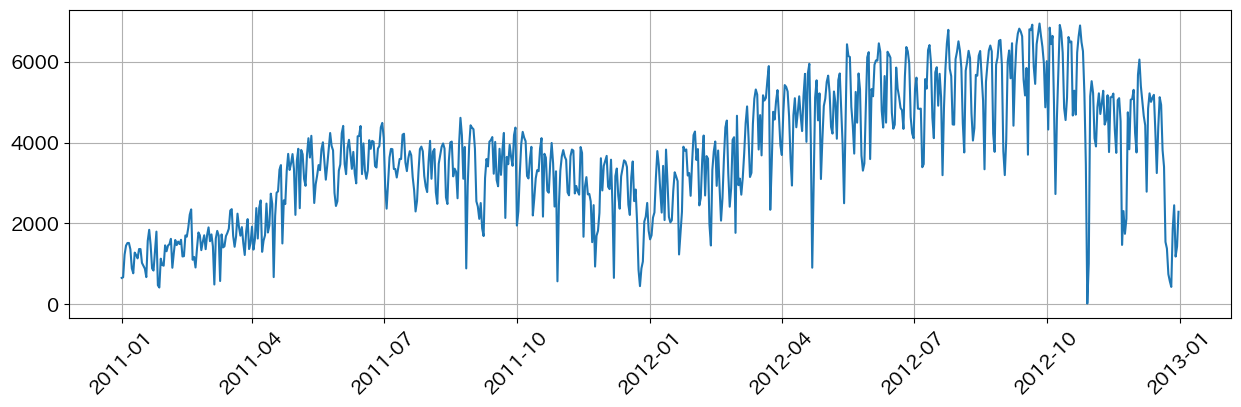

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(df['dteday'], df['registered'])
ax.tick_params(axis = 'x', rotation = 45)
ax.grid()
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

### 欠損値の確認
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3行目: dteday列（`df['dteday']`）を日付クラス（`datetime64[ns]`）に変換
* 4行目: `isnull`メソッドと`sum`メソッドを組み合わせて，各列の欠損値の数を計算して，`display`関数で表示する

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
display(pd.DataFrame(df.isnull().sum(), columns = ['欠損値の数']))

,欠損値の数
dteday,0
season,0
yr,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,2
atemp,2


### 欠損値の可視化
* temp列，atemp列，hum列，windspeed列に欠損値があることが確認できた
* 次に，欠損値のあるデータの前後の推移を確認する
* 欠損値はインデックス201と202のデータにある（本当は検索する必要がある）ので，その前後を取り出して可視化する
* DataFrameの特定のインデックス範囲，特定の列のデータを取り出すには，`df[インデックス範囲][列名のリスト]`と記述する
* 詳細は，共通資料「[ノートブック：SeriesとDataFrameの基本操作](https://colab.research.google.com/github/yoshida-nu/lec_datascience/blob/main/doc/datascience_notebook_se_df.ipynb)」を参照
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3行目: dteday列（`df['dteday']`）を日付クラス（`datetime64[ns]`）に変換
* 4行目: 欠損値のある列の名前をリスト`['temp', 'atemp', 'hum', 'windspeed']`を変数`x_cols`に代入
* 5行目: `plot`関数で欠損値の周辺（`df[185:215][x_cols]`）のデータに対するグラフを作成
>* `label = x_cols`で，凡例に表示するラベルを設定
* 6行目: `legend`関数で凡例を表示
>* `bbox_to_anchor = (1,1)`で凡例の位置を右上に指定
* 7行目: `show`関数で，それまでに設定した図を実行画面に表示

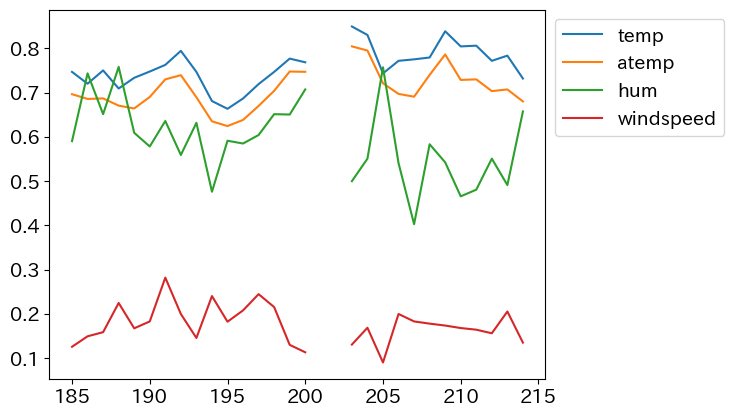

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
x_cols = ['temp', 'atemp', 'hum', 'windspeed']
plt.plot(df[185:215][x_cols], label = x_cols)
plt.legend(bbox_to_anchor = (1,1))
plt.show()

### 欠損値への対処
* 線形補間を使って欠損値の穴埋めをする
* また，線形補間した結果をグラフで可視化し，確認する
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3行目: dteday列（`df['dteday']`）を日付クラス（`datetime64[ns]`）に変換
* 4行目: 欠損値のある列の名前をリスト`['temp', 'atemp', 'hum', 'windspeed']`を変数`x_cols`に代入
* 5行目: `interpolate`メソッドで，欠損値のある列（`df[x_cols]`）に線形補間を施す
* 6～8行目: 1つ前のコードと同様にして，欠損値の周辺（`df[x_cols].loc[185:215]`）のデータに対するグラフを作成

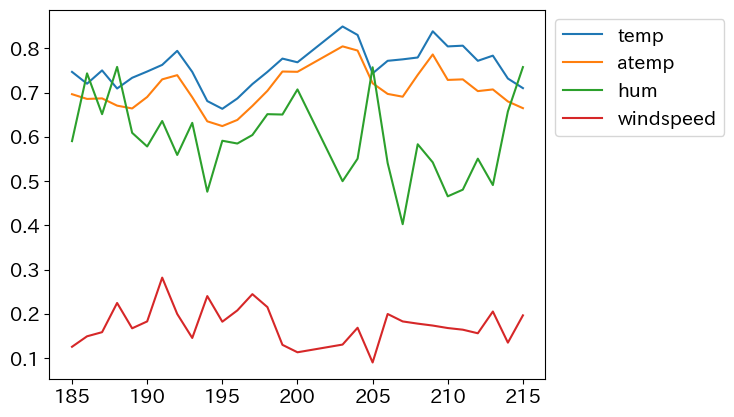

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
x_cols = ['temp', 'atemp', 'hum', 'windspeed']
df[x_cols] = df[x_cols].interpolate()
plt.plot(df[x_cols].loc[185:215], label = x_cols)
plt.legend(bbox_to_anchor = (1,1))
plt.show()

## 時系列分析の方法
* 時系列データに対する分析で使われる主な方法には，時系列分析と回帰分析（回帰モデルの学習）がある
* 時系列分析に必要なデータは，時間に関する情報（日付や時間など）と，その時点で観測した目的変数の値である
* これに対して，回帰分析の場合は， 目的変数と関連がありそうな様々な情報が必要となる
* ここでは，自転車データに対して，時系列分析と回帰分析をそれぞれ実践する
* なお，時系列分析には，高度な数学的知識が必要であるが，本講義ではこの点について一切触れないことにする

## 回帰分析（線形回帰モデルの学習）
* 一般に，回帰分析では，特徴量として日付データは用いない
* 日付データは時系列分析で用いられる

### 外れ値の対処
* ここでは，`temp`, `atemp`, `hum`, `windspeed`（欠損値のある列と同じ）に対するマハラノビス距離の四分位範囲による判定基準に基づき，外れ値を判定する
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3行目: dteday列（`df['dteday']`）を日付クラス（`datetime64[ns]`）に変換
* 4行目: 列名のリスト`['temp', 'atemp', 'hum', 'windspeed']`を変数`x_cols`に代入
* 5行目: `interpolate`メソッドで，欠損値のある列（`df[x_cols]`）に線形補間を施す
* 6行目: `sklearn` (scikit-learn) の`cobariance`モジュール内にある`MinCovDet`クラスを読み込む
* 7行目: `MinCovDet`クラスのオブジェクトを生成し，変数`mcd`に代入
>* 乱数の種を `random_state = random_seed` で指定
* 8～9行目: 生成したオブジェクトに対して，`fit`メソッドと`mahalanobis`メソッドを順番に呼び出し，マハラノビス距離を計算
>* いずれのメソッドの引数にも `df[x_cols]`を指定
>* 計算結果を変数`distance`に代入
* 10行目: `DataFrame`関数で，`distance`をDataFrameに変換
* 11行目: `concat`関数で，2つのDataFrame `df`と`distance` を結合し，その結果を`df`に代入
* 12行目: `quantile`メソッドで，マハラノビス距離（`df['マハラノビス距離']`）の第1四分位数を計算し，変数`q1`に代入
* 13行目: `quantile`メソッドで，マハラノビス距離（`df['マハラノビス距離']`）の第3四分位数を計算し，変数`q3`に代入
* 14行目: `q3 - q1`で IQRを計算し，変数`iqr`に代入
* 15行目: 判定基準の上限値を計算し，変数`upper`に代入
* 16行目: 判定基準の下限値を計算し，変数`lower`に代入
* 17行目: `df`から，判定基準を満たすデータを検索し，結果を変数`df_out`に代入
* 18行目: `drop`メソッドを使って，`df`から外れ値と判定されたインデックス（`df_out.index`）のデータを削除し，その結果を`df`に代入
* 19行目: `display`関数で，`df` を表示

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
x_cols = ['temp', 'atemp', 'hum', 'windspeed']
df[x_cols] = df[x_cols].interpolate()
from sklearn.covariance import MinCovDet
mcd = MinCovDet(random_state = random_seed)
mcd.fit(df[x_cols])
distance = mcd.mahalanobis(df[x_cols])
distance = pd.DataFrame(distance, columns = ['マハラノビス距離'])
df = pd.concat([df, distance], axis = 1)
q1 = df['マハラノビス距離'].quantile(0.25)
q3 = df['マハラノビス距離'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
df_out = df[(df['マハラノビス距離'] > upper) | (df['マハラノビス距離'] < lower)]
df = df.drop(df_out.index, axis = 0)
display(df)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,マハラノビス距離
0,2011-01-01,1,0,1,0,6,0,2,0.344,0.364,0.806,0.160,331,654,985,5.113
1,2011-01-02,1,0,1,0,0,0,2,0.363,0.354,0.696,0.249,131,670,801,3.737
3,2011-01-04,1,0,1,0,2,1,1,0.200,0.212,0.590,0.160,108,1454,1562,5.773
4,2011-01-05,1,0,1,0,3,1,1,0.227,0.229,0.437,0.187,82,1518,1600,9.246
5,2011-01-06,1,0,1,0,4,1,1,0.204,0.233,0.518,0.090,88,1518,1606,6.929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2012-12-24,1,1,12,0,1,1,2,0.231,0.259,0.791,0.077,174,746,920,6.251
724,2012-12-25,1,1,12,1,2,0,2,0.291,0.294,0.735,0.169,440,573,1013,3.380
727,2012-12-28,1,1,12,0,5,1,2,0.253,0.255,0.590,0.155,644,2451,3095,5.640
728,2012-12-29,1,1,12,0,6,0,2,0.253,0.242,0.753,0.124,159,1182,1341,13.483


### データの分割
* 目的変数： `registered`（登録ユーザー利用数）
* 説明変数： `season`（季節），`yr`（年），`mnth`（月），`holiday`（祝日），`weekday`（曜日），`workingday`（週末でも祝日でもない），`weathersit`（天気），`temp`（気温），`atemp`（体感気温），`hum`（湿度），`windspeed`（風速）
>* `dteday`（日付），`casual`（臨時ユーザー利用数），`registered`（登録ユーザー利用数），`cnt`（全体ユーザー利用数 ）以外のすべて
>* 後から追加した `マハラノビス距離` も説明変数には含めない
* 議論を簡単にするため，モデルのチューニングは行わない
>* つまり，訓練/検証データとテストデータへの分割は行わず，訓練データとテストデータの分割を行う
* これまでは全体のデータから乱数を使って訓練データとテストデータに分割していたが，時系列データに対する訓練データとテストデータの分割はこれまではとは異なる方法をとる
* 時系列データの分析の目的は，過去の目的変数の値をもとに，未来の目的変数の値を予測することなので，データ全体の中から特定の日付を選び，その日より前のデータを訓練データ，残りのデータをテストデータとする
* ここでは，「2012年11月1日」を基準にして訓練データとテストデータに分割する
* 分割の手順は以下のとおり
>* すべてのデータに対して，目的変数（`registered`）と説明変数（`dteday`, `casual`, `registered`, `cnt`以外）に分割する
>* 2012年11月1日を基準にして，訓練データとテストデータに分割したときのインデックス`train_index`, `test_index`をそれぞれ取り出す
* また，モデルのチューニングと同様に，データの標準化も行わない
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～18行目: データの前処理
* 19行目: 説明変数の列名を要素とするリスト`['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']`を変数`x_cols`に代入
* 20行目: 目的変数の列名（リスト）`['registered']`を変数`t_col`に代入
* 21行目: DataFrame `df` から,`df[x_cols]`で，説明変数の列だけ取り出し変数`x`に代入
* 22行目: DataFrame `df` から,`df[t_col]`で目的変数の列だけ取り出し変数`t`に代入
* 23行目: `pd.to_datetime('2012-11-1')`で，基準日「2012年11月1日」に対応する日付データを取得し，変数`mday`に代入
* 24行目: `df['dteday'] < mday`で，基準日以前（基準日は含まない）が`True`，それ以外が`False`となるSeriesを生成し，`train_index`に代入
* 25行目: `df['dteday'] >= mday`で，基準日以降が`True`，それ以外が`False`となるSeriesを生成し，`test_index`に代入
* 26行目: `x[train_index]`で，基準日以前（基準日は含まない）の説明変数データ（`train_index`が`True`のデータ）を取り出し，`x_train`に代入
* 27行目: `x[test_index]`で，基準日以降の説明変数データ（`test_index`が`True`のデータ）を取り出し，`x_test`に代入
* 28行目: `t[train_index]`で，基準日以前（基準日は含まない）の目的変数データ（`train_index`が`True`のデータ）を取り出し，`t_train`に代入
* 29行目: `t[test_index]`で，基準日以降の目的変数データ（`test_index`が`True`のデータ）を取り出し，`t_test`に代入
* 30行目: `print`関数で区切り線「================ x_train ================」を表示
* 31行目: `display`関数で変数`x_train`（訓練データの説明変数データ）を表示
* 32行目: `print`関数で区切り線「================ t_train ================」を表示
* 33行目: `display`関数で変数`t_train`（訓練データの目的変数データ）を表示
* 34行目: `print`関数で区切り線「================ x_test ================」を表示
* 35行目: `display`関数で変数`x_test`（テストデータの説明変数データ）を表示
* 36行目: `print`関数で区切り線「================ t_test ================」を表示
* 37行目: `display`関数で変数`t_test`（テストデータの目的変数データ）を表示



In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
x_cols = ['temp', 'atemp', 'hum', 'windspeed']
df[x_cols] = df[x_cols].interpolate()
from sklearn.covariance import MinCovDet
mcd = MinCovDet(random_state = random_seed)
mcd.fit(df[x_cols])
distance = mcd.mahalanobis(df[x_cols])
distance = pd.DataFrame(distance, columns = ['マハラノビス距離'])
df = pd.concat([df, distance], axis = 1)
q1 = df['マハラノビス距離'].quantile(0.25)
q3 = df['マハラノビス距離'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
df_out = df[(df['マハラノビス距離'] > upper) | (df['マハラノビス距離'] < lower)]
df = df.drop(df_out.index, axis = 0)
x_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
t_col = ['registered']
x = df[x_cols]
t = df[t_col]
mday = pd.to_datetime('2012-11-1')
train_index = df['dteday'] < mday
test_index = df['dteday'] >= mday
x_train = x[train_index]
x_test = x[test_index]
t_train = t[train_index]
t_test = t[test_index]
print('================ x_train ================')
display(x_train)
print('================ t_train ================')
display(pd.DataFrame(t_train))
print('================ x_test ================')
display(x_test)
print('================ t_test ================')
display(pd.DataFrame(t_test))

================ x_train ================


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,0,1,0,6,0,2,0.344,0.364,0.806,0.160
1,1,0,1,0,0,0,2,0.363,0.354,0.696,0.249
3,1,0,1,0,2,1,1,0.200,0.212,0.590,0.160
4,1,0,1,0,3,1,1,0.227,0.229,0.437,0.187
5,1,0,1,0,4,1,1,0.204,0.233,0.518,0.090
...,...,...,...,...,...,...,...,...,...,...,...
665,4,1,10,0,6,0,2,0.530,0.515,0.720,0.236
666,4,1,10,0,0,0,2,0.477,0.468,0.695,0.398
667,4,1,10,0,1,1,3,0.440,0.439,0.880,0.358
668,4,1,10,0,2,1,2,0.318,0.310,0.825,0.213


================ t_train ================


,registered
0,654
1,670
3,1454
4,1518
5,1518
...,...
665,5209
666,3461
667,20
668,1009


================ x_test ================


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
670,4,1,11,0,4,1,2,0.366,0.370,0.582,0.157
671,4,1,11,0,5,1,1,0.355,0.356,0.522,0.266
672,4,1,11,0,6,0,2,0.343,0.324,0.491,0.271
673,4,1,11,0,0,0,1,0.326,0.330,0.533,0.179
674,4,1,11,0,1,1,1,0.319,0.308,0.494,0.236
675,4,1,11,0,2,1,1,0.281,0.282,0.567,0.174
677,4,1,11,0,4,1,1,0.352,0.342,0.333,0.348
678,4,1,11,0,5,1,1,0.362,0.355,0.541,0.215
679,4,1,11,0,6,0,1,0.389,0.394,0.645,0.058
680,4,1,11,0,0,0,1,0.421,0.422,0.659,0.128


================ t_test ================


,registered
670,5520
671,5229
672,4109
673,3906
674,4881
675,5220
677,4975
678,5283
679,4446
680,4562


### モデルの学習と評価
* 訓練データでモデルを学習し，テストデータを使ってモデルの評価（決定係数の計算）を行う
* 以下のコードで学習と評価を行った結果，訓練データに対する当てはまりは良かったが，テストデータに対する当てはまりが悪くなった
* このモデルでは，予測がうまくできていないので，モデルのチューニング等を行って改善を図る必要があるが，今回はここまでとする
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～18行目: データの前処理
* 19行目: 説明変数の列名を要素とするリスト`['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']`を変数`x_cols`に代入
* 20行目: 目的変数の列名（リスト）`['registered']`を変数`t_col`に代入
* 21行目: DataFrame `df` から,`df[x_cols]`で，説明変数の列だけ取り出し変数`x`に代入
* 22行目: DataFrame `df` から,`df[t_col]`で目的変数の列だけ取り出し変数`t`に代入
* 23行目: `pd.to_datetime('2012-11-1')`で，基準日「2012年11月1日」に対応する日付データを取得し，変数`mday`に代入
* 24行目: `df['dteday'] < mday`で，基準日以前（基準日は含まない）が`True`，それ以外が`False`となるSeriesを生成し，`train_index`に代入
* 25行目: `df['dteday'] >= mday`で，基準日以降が`True`，それ以外が`False`となるSeriesを生成し，`test_index`に代入
* 26行目: `x[train_index]`で，基準日以前（基準日は含まない）の説明変数データ（`train_index`が`True`のデータ）を取り出し，`x_train`に代入
* 27行目: `x[test_index]`で，基準日以降の説明変数データ（`test_index`が`True`のデータ）を取り出し，`x_test`に代入
* 28行目: `t[train_index]`で，基準日以前（基準日は含まない）の目的変数データ（`train_index`が`True`のデータ）を取り出し，`t_train`に代入
* 29行目: `t[test_index]`で，基準日以降の目的変数データ（`test_index`が`True`のデータ）を取り出し，`t_test`に代入
* 30行目:  `sklearn` (scikit-learn) の`linear_model`モジュール内にある`LinearRegression`クラスを読み込む
* 31行目: `LinearRegression()`で，線形回帰モデルの学習を行うためのオブジェクトを`LinearRegression`クラスから生成し，変数`linear_regression_model`に代入
* 32行目: 訓練データ（`x_train`と`t_train`）を用いて，`fit`メソッドで線形回帰モデルの学習を実行
* 33行目: `linear_regression_model.score(X = x_train, y = t_train)`で，標準化した訓練データに対する決定係数を計算して変数`score_train`に代入
* 34行目: `linear_regression_model.score(X = x_test, y = t_test)`で，標準化したテストデータに対する決定係数を計算して変数`score_test`に代入
* 35行目: `print`関数とf-stringを使って，訓練データに対する精度（`score_train`）とテストデータに対する精度（`score_test`）を小数点以下3桁まで表示
* 36行目: `coef_`属性から回帰係数（定数項以外）を取り出し，変数`a`に代入
* 37行目: `intercept_`属性から定数項を取り出し，変数`b`に代入
* 38行目: `print`関数とf-stringを使って，回帰係数`a`を表示
* 39行目: `print`関数とf-stringを使って，定数項`b`を表示

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
x_cols = ['temp', 'atemp', 'hum', 'windspeed']
df[x_cols] = df[x_cols].interpolate()
from sklearn.covariance import MinCovDet
mcd = MinCovDet(random_state = random_seed)
mcd.fit(df[x_cols])
distance = mcd.mahalanobis(df[x_cols])
distance = pd.DataFrame(distance, columns = ['マハラノビス距離'])
df = pd.concat([df, distance], axis = 1)
q1 = df['マハラノビス距離'].quantile(0.25)
q3 = df['マハラノビス距離'].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
df_out = df[(df['マハラノビス距離'] > upper) | (df['マハラノビス距離'] < lower)]
df = df.drop(df_out.index, axis = 0)
x_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
t_col = ['registered']
x = df[x_cols]
t = df[t_col]
mday = pd.to_datetime('2012-11-1')
train_index = df['dteday'] < mday
test_index = df['dteday'] >= mday
x_train = x[train_index]
x_test = x[test_index]
t_train = t[train_index]
t_test = t[test_index]
from sklearn.linear_model import LinearRegression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X = x_train, y = t_train)
score_train = linear_regression_model.score(X = x_train, y = t_train)
score_test = linear_regression_model.score(X = x_test, y = t_test)
print(f'訓練データの決定係数={score_train:.3f} / テストデータの決定係数={score_test:.3f}')
a = linear_regression_model.coef_
b = linear_regression_model.intercept_
print(f'回帰係数（定数項以外）: {a}')
print(f'定数項: {b}')

訓練データの決定係数=0.827 / テストデータの決定係数=0.375
回帰係数（定数項以外）: [[  290.64   1872.154    44.386   -80.663    40.555   940.476  -454.717
  -1639.09   5153.134  -880.63  -1534.067]]
定数項: [855.613]


## 時系列分析
* 基本的な時系列分析では，目的変数とそれに対応する日付等の（時点情報）のみを使う（発展形として他の項目を使う方法もある）

### 時系列分析用のライブラリ
* 時系列分析で使われるモデルは，線形回帰モデルや文類木などと比較して取り扱いが難しいモデルになる
* Pythonを使って実装する場合でも，ある程度の時系列分析に関する数学的知識が必要であったため，利用のハードルが高かった
* しかし，2017年にFacebook社が「Prophet（プロフェット）」と呼ばれる時系列分析用のライブラリを公開したことで，従来と比較して簡単にモデルを作れるようになった
* ここでは，Prophetを用いたモデルの学習を実装する

### データの分割
* 目的変数を`registered`（登録ユーザー利用数），説明変数を`dteday`（日付）とし，回帰分析と同様に訓練データとテストデータを2012年11月1日を基準にして分割する
* また，Prophetを用いるためには，列名を規則に従った名前（DataFrameの列名）にする必要があるので，`registered`と`dteday`を`y`と`ds`にそれぞれ置き換える
* DataFrameの列名は，`rename`メソッドで変更することで変更できる
* 列名変更の書式: `df.rename(columns = {'変更前の列名1': '変更後の列名1', '変更前の列名2': '変更後の列名2', ...}, inplace = True)`
>* `columns`で変更前と変更後の列名をディクショナリ（`dict`）形式で指定する
>* `inplace = True`でDataFrameを直接変更する（変更が元のDataFrameに反映される）
>* `inplace = False`（デフォルト）とすると，列名を変更した新たなDataFrameが作成される
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3行目: `to_datetime`関数で dteday列（`df['dteday']`）を日付・時刻データに対応するクラスに変換し，その結果を`df['dteday']`に代入
* 4行目: `df`から目的変数と説明変数の2列（`df[['dteday', 'registered']]`）を取り出し，変数`data`に代入
* 5行目: `rename`メソッドを使って，`data`の列名 `dteday`と`registered` をそれぞれ`ds`と`y`に変更
* 6行目: `pd.to_datetime('2012-11-1')`で，基準日「2012年11月1日」に対応する日付データを取得し，変数`mday`に代入
* 7行目: `data['ds'] < mday`で，基準日以前（基準日は含まない）が`True`，それ以外が`False`となるSeriesを生成し，`train_index`に代入
* 8行目: `data['ds'] >= mday`で，基準日以降が`True`，それ以外が`False`となるSeriesを生成し，`test_index`に代入
* 9行目: `data[train_index]`で，基準日以前（基準日は含まない）の説明変数データ（`train_index`が`True`のデータ）を取り出し，`data_train`に代入
* 10行目: `data[test_index]`で，基準日以降の説明変数データ（`test_index`が`True`のデータ）を取り出し，`data_test`に代入
* 11行目: `print`関数で区切り線「================ data_train ================」を表示
* 12行目: `display`関数で変数`data_train`（訓練データ）を表示
* 13行目: `print`関数で区切り線「================ data_test ================」を表示
* 14行目: `display`関数で変数`data_test`（テストデータ）を表示

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
data = df[['dteday', 'registered']]
data.rename(columns = {'dteday': 'ds', 'registered': 'y'}, inplace = True)
mday = pd.to_datetime('2012-11-1')
train_index = data['ds'] < mday
test_index = data['ds'] >= mday
data_train = data[train_index]
data_test = data[test_index]
print('================ data_train ================')
display(data_train)
print('================ data_train ================')
display(data_test)

================ data_train ================


,ds,y
0,2011-01-01,654
1,2011-01-02,670
2,2011-01-03,1229
3,2011-01-04,1454
4,2011-01-05,1518
...,...,...
665,2012-10-27,5209
666,2012-10-28,3461
667,2012-10-29,20
668,2012-10-30,1009


================ data_train ================


,ds,y
670,2012-11-01,5520
671,2012-11-02,5229
672,2012-11-03,4109
673,2012-11-04,3906
674,2012-11-05,4881
...,...,...
726,2012-12-27,1867
727,2012-12-28,2451
728,2012-12-29,1182
729,2012-12-30,1432


### Prophetによる時系列モデルの学習
* prophetモジュールの`Prophet`クラスを読み込む: `from prophet import Prophet`
* モデルの学習を行うためのオブジェクトを生成する
>* `変数 = Prophet(yearly_seasonality = True, weekly_seasonality = True, seasonality_mode = 'multiplicative')`
>* 本講義においては，3つの引数の意味を理解する必要はない
* これまでと同様に，`fit`メソッドでモデルの学習を行う

### 参考: 3つの引数
* `yearly_seasonality = True` ⇒ 年単位の周期性（シーズナリティ）考慮する
>* 年単位での変動（夏と冬のパターンの違いなど）をモデルに取り入れる
* `weekly_seasonality = True` ⇒ 週単位の周期性（シーズナリティ）の有無を考慮する
>* 週単位での変動（平日と週末のパターンの違いなど）をモデルに取り入れる
* `seasonality_mode = 'multiplicative'` ⇒ 乗法モデル
>* 乗法モデルは，周期性の影響がデータのレベルに比例して変動する場合に有効となる
>* 自転車データのように，利用者数が増えると変動幅も大きくなるデータに対して使用する
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～10行目: データの前処理
* 11行目: prophetモジュールの`Prophet`クラスを読み込む
* 12行目: 時系列モデルの学習を行うためのオブジェクトを`Prophet`クラスから生成し，変数`model_prophet`に代入
* 13行目: 訓練データ（`data_train`）を用いて，`fit`メソッドでモデルの学習を実行（実行結果は気にしなくてよい）


In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
data = df[['dteday', 'registered']]
data.rename(columns = {'dteday': 'ds', 'registered': 'y'}, inplace = True)
mday = pd.to_datetime('2012-11-1')
train_index = data['ds'] < mday
test_index = data['ds'] >= mday
data_train = data[train_index]
data_test = data[test_index]
from prophet import Prophet
model_prophet = Prophet(yearly_seasonality = True, weekly_seasonality = True, seasonality_mode = 'multiplicative')
model_prophet.fit(data_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/s23mycz0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/pv8og_q0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20820', 'data', 'file=/tmp/tmp6o78k91k/s23mycz0.json', 'init=/tmp/tmp6o78k91k/pv8og_q0.json', 'output', 'file=/tmp/tmp6o78k91k/prophet_modellj3drofd/prophet_model-20250317012926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:29:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:29:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### 予測用データの作成
* 学習したモデルを使って，未来のデータ（日付）に対する予測ができる
* そのために，予測したい未来の日付（2012年11月1日以降）データが入った予測用データを作成する
* 予測用データは，`Prophet`オブジェクトの`make_future_dataframe`メソッドで作成する
* 書式: `変数.make_future_dataframe(periods = [予測したい日数], freq = [日付の間隔])`  
* `make_future_dataframe`メソッドの戻り値は，日付`ds`だけが入ったDataFrameで，訓練データの日付と予測したい日付が生成される
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～10行目: データの前処理
* 11～13行目: モデルの学習
* 14行目: `make_future_dataframe`メソッドで予測用データを作成し，変数`future`に代入
>* `periods = 61` は予測したい日数（2012-11-1 から2012-12-31）
>* `freq`は日付の間隔を指定する引数で，`freq = 'D'`とすると間隔が1日単位になる
* 15行目: `display`関数で`future`の内容を表示

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
data = df[['dteday', 'registered']]
data.rename(columns = {'dteday': 'ds', 'registered': 'y'}, inplace = True)
mday = pd.to_datetime('2012-11-1')
train_index = data['ds'] < mday
test_index = data['ds'] >= mday
data_train = data[train_index]
data_test = data[test_index]
from prophet import Prophet
model_prophet = Prophet(yearly_seasonality = True, weekly_seasonality = True, seasonality_mode = 'multiplicative')
model_prophet.fit(data_train)
future = model_prophet.make_future_dataframe(periods = 61, freq = 'D')
display(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/e0stoa_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/q_9vvlf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59306', 'data', 'file=/tmp/tmp6o78k91k/e0stoa_m.json', 'init=/tmp/tmp6o78k91k/q_9vvlf6.json', 'output', 'file=/tmp/tmp6o78k91k/prophet_model8g94ruqg/prophet_model-20250317012920.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:29:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:29:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
0,2011-01-01
1,2011-01-02
2,2011-01-03
3,2011-01-04
4,2011-01-05
...,...
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30


### 予測用データに対する学習済みモデルによる予測
* 次に，予測用データを使って予測をする
* 予測は線形回帰モデルなどと同様に，`predict`メソッドを用いる
* 詳細は省略するが，`predict`メソッドの戻り値は DataFrameとなり，目的変数の予測値（`yhat`），時系列データのトレンド（長期的傾向），周期性などに関する様々な情報を含んでいる
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～10行目: データの前処理
* 11～13行目: モデルの学習
* 14～15行目: 予測用データの作成
* 16行目: `predict`メソッドを使って，予測用データに対する予測を行い，その結果を変数`forecast`に代入
* 17行目: `display`メソッドで，予測値`yhat`を含んだ DataFrame `forecast`の内容を表示

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
data = df[['dteday', 'registered']]
data.rename(columns = {'dteday': 'ds', 'registered': 'y'}, inplace = True)
mday = pd.to_datetime('2012-11-1')
train_index = data['ds'] < mday
test_index = data['ds'] >= mday
data_train = data[train_index]
data_test = data[test_index]
from prophet import Prophet
model_prophet = Prophet(yearly_seasonality = True, weekly_seasonality = True, seasonality_mode = 'multiplicative')
model_prophet.fit(data_train)
future = model_prophet.make_future_dataframe(periods = 61, freq = 'D')
forecast = model_prophet.predict(future)
display(forecast[['ds', 'yhat']])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/9vc3gj0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/rayyk0kg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82374', 'data', 'file=/tmp/tmp6o78k91k/9vc3gj0h.json', 'init=/tmp/tmp6o78k91k/rayyk0kg.json', 'output', 'file=/tmp/tmp6o78k91k/prophet_model4takf228/prophet_model-20250317012911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:29:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:29:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat
0,2011-01-01,685.869
1,2011-01-02,601.423
2,2011-01-03,943.149
3,2011-01-04,1100.123
4,2011-01-05,1164.781
...,...,...
726,2012-12-27,3918.972
727,2012-12-28,3606.881
728,2012-12-29,2335.491
729,2012-12-30,2014.463


### モデルの評価

#### トレンドと周期性
* `predict`メソッドによる予測結果`forecast`を引数として`plot_components`メソッドを呼び出すことで，トレンド，週単位の周期性，年単位の周期性を示す3つのグラフが作成できる  
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～10行目: データの前処理
* 11～13行目: モデルの学習
* 14～15行目: 学習済みモデルによる予測
* 16行目: `plot_components`メソッドで，トレンド，週単位の周期性，年単位の周期性を示す3つのグラフを作成
* 17行目: `show`関数で，それまでに設定した図を実行画面に表示

**［結果の読み取り］**
*  トレンドを示す1つ目のグラフから，利用数は増加傾向であることが読み取れる
*  週単位の周期性を示す2つ目のグラフから，平日の利用が多く，土日は少ない傾向があることが読み取れる
*  年単位の周期性を示す3つ目のグラフから，夏に利用が多く，冬は少ない傾向があることが読み取れる

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/ywbmbv2r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/ylv9grdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63172', 'data', 'file=/tmp/tmp6o78k91k/ywbmbv2r.json', 'init=/tmp/tmp6o78k91k/ylv9grdz.json', 'output', 'file=/tmp/tmp6o78k91k/prophet_modelzwi29oxs/prophet_model-20250317012850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:28:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:28:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


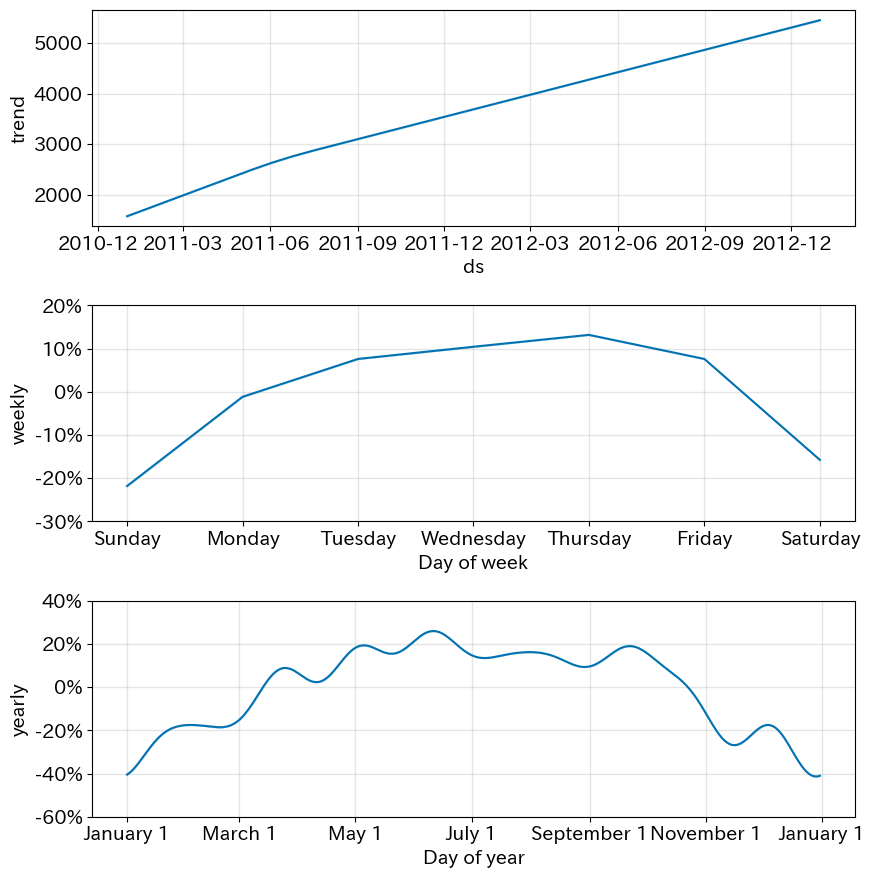

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
data = df[['dteday', 'registered']]
data.rename(columns = {'dteday': 'ds', 'registered': 'y'}, inplace = True)
mday = pd.to_datetime('2012-11-1')
train_index = data['ds'] < mday
test_index = data['ds'] >= mday
data_train = data[train_index]
data_test = data[test_index]
from prophet import Prophet
model_prophet = Prophet(yearly_seasonality = True, weekly_seasonality = True, seasonality_mode = 'multiplicative')
model_prophet.fit(data_train)
future = model_prophet.make_future_dataframe(periods = 61, freq = 'D')
forecast = model_prophet.predict(future)
model_prophet.plot_components(forecast)
plt.show()

#### 訓練データとテストデータに対する予測結果の可視化
* `plot`メソッドを使って，予測用データに対する予測結果（`predict`メソッドの戻り値）を可視化する  
* 書式: `変数.plot(予測結果, ax = Axesオブジェクト)`
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～10行目: データの前処理
* 11～13行目: モデルの学習
* 14～15行目: 学習済みモデルによる予測
* 16行目: `sublots`関数を使って，`Figure`オブジェクトと`Axes`オブジェクトを生成し，変数 `fig` と `ax` にそれぞれ代入
>* `figsize = (15, 6)`で，サイズ指定も同時に行う
* 17行目: `model_prophet`に対する`plot`メソッドを使って，予測結果を可視化
* 18行目: `ax`に対する`tick_params`メソッドを使って，x軸ラベル（`axis = 'x'`）を45度回転（`rotation = 45`）
* 19行目: `ax`に対する`set_xlabel`メソッドを使って，x軸ラベルのタイトルを「日付」に設定
* 20行目: `ax`に対する`set_ylabel`メソッドを使って，y軸ラベルのタイトルを「利用数」に設定
* 21行目: `show`関数で，それまでに設定した図を実行画面に表示
  
**［結果の読み取り］**
* 作成された図には，中央の青色の線と，その上下のやや薄い水色の線がある
* Prophetによる時系列分析の予測結果は1点ではなく，「80%の確率でこの範囲に含まれる」という形の予測をしている
* したがって，薄い水色の領域は，80％の確率で真の値が含まれる範囲（信頼区間と呼ぶ）を示している
* 黒色の点は実際の正解データを示している
* 水色の領域から外れている黒色の点は，正解データが予測結果の80%信頼区間から外れているので，正確な予測ができなかったことを意味している


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/5n_1lfq5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/p5eohby8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85204', 'data', 'file=/tmp/tmp6o78k91k/5n_1lfq5.json', 'init=/tmp/tmp6o78k91k/p5eohby8.json', 'output', 'file=/tmp/tmp6o78k91k/prophet_modelzph_7_5_/prophet_model-20250317015257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:52:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:52:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


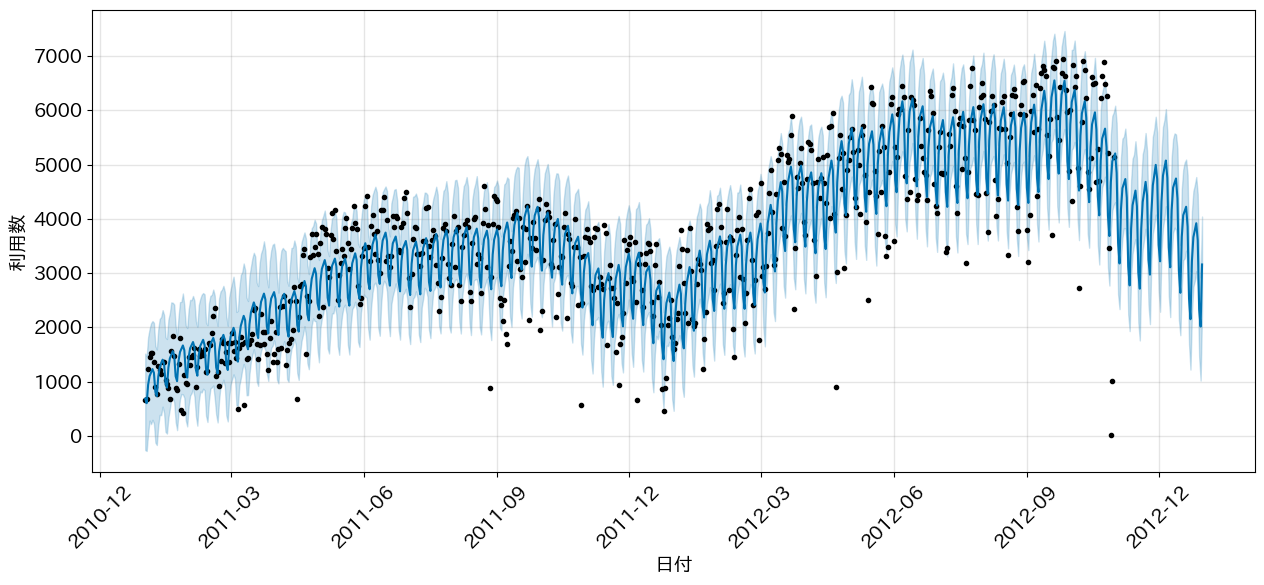

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
data = df[['dteday', 'registered']]
data.rename(columns = {'dteday': 'ds', 'registered': 'y'}, inplace = True)
mday = pd.to_datetime('2012-11-1')
train_index = data['ds'] < mday
test_index = data['ds'] >= mday
data_train = data[train_index]
data_test = data[test_index]
from prophet import Prophet
model_prophet = Prophet(yearly_seasonality = True, weekly_seasonality = True, seasonality_mode = 'multiplicative')
model_prophet.fit(data_train)
future = model_prophet.make_future_dataframe(periods = 61, freq = 'D')
forecast = model_prophet.predict(future)
fig, ax = plt.subplots(figsize = (15, 6))
model_prophet.plot(forecast, ax = ax)
ax.tick_params(axis = 'x', rotation = 45)
ax.set_xlabel('日付')
ax.set_ylabel('利用数')
plt.show()

#### 正解データと予測結果の比較
* テストデータに対する期間中（2012年11月1日～2012年12月31日）の予測結果のみを取り出し，正解データと比較したグラフを作成する
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～10行目: データの前処理
* 11～13行目: モデルの学習
* 14～15行目: 学習済みモデルによる予測
* 16行目: 予測結果`forecast`から，テストデータに対する期間（2012年11月1日～2012年12月31日）における予測値が入っている列（`forecast[-61:][['yhat']]`）のみ抽出し，変数`y_pred`に代入
>* `[-61:]` は最後のデータから数えて61番目以降という意味
* 17行目: `sublots`関数を使って，`Figure`オブジェクトと`Axes`オブジェクトを生成し，変数 `fig` と `ax` にそれぞれ代入
>* `figsize = (10, 4)`で，サイズ指定も同時に行う
* 18行目: `ax`に対する`plot`メソッドを使って，正解データを可視化
>* x軸を日付`data_test['ds']`，y軸を正解データ`data_test['y']`とする
>* `color='black'`で線の色を黒に設定
>* `label = '正解データ'`で凡例に表示するラベルを設定
* 19行目: `ax`に対する`plot`メソッドを使って，予測結果を可視化
>* x軸を日付`data_test['ds']`，y軸を予測結果`y_pred`とする
>* `color='blue'`で線の色を青に設定
>* `label = '予測結果'`で凡例に表示するラベルを設定
* 20行目: `ax`に対する`tick_params`メソッドを使って，x軸ラベル（`axis = 'x'`）を45度回転（`rotation = 45`）
* 21行目: `ax`に対する`grid`メソッドでグリッド線を表示
* 22行目: `ax`に対する`legend`メソッドで凡例を表示
* 23行目: `show`関数で，それまでに設定した図を実行画面に表示


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/ppyrtvb2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/3scsxswy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49468', 'data', 'file=/tmp/tmp6o78k91k/ppyrtvb2.json', 'init=/tmp/tmp6o78k91k/3scsxswy.json', 'output', 'file=/tmp/tmp6o78k91k/prophet_modelltwm728d/prophet_model-20250317022823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:28:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:28:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


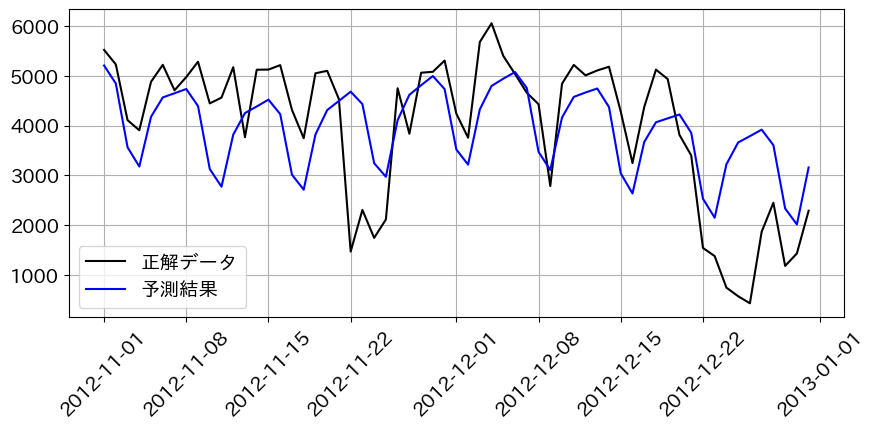

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
data = df[['dteday', 'registered']]
data.rename(columns = {'dteday': 'ds', 'registered': 'y'}, inplace = True)
mday = pd.to_datetime('2012-11-1')
train_index = data['ds'] < mday
test_index = data['ds'] >= mday
data_train = data[train_index]
data_test = data[test_index]
from prophet import Prophet
model_prophet = Prophet(yearly_seasonality = True, weekly_seasonality = True, seasonality_mode = 'multiplicative')
model_prophet.fit(data_train)
future = model_prophet.make_future_dataframe(periods = 61, freq = 'D')
forecast = model_prophet.predict(future)
y_pred = forecast[-61:][['yhat']]
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(data_test['ds'], data_test['y'], color='black', label = '正解データ')
ax.plot(data_test['ds'], y_pred, color='blue', label='予測結果')
ax.tick_params(axis = 'x', rotation = 45)
ax.grid()
ax.legend()
plt.show()

#### 決定係数の計算
* 学習したモデルの当てはまりの良さを測る決定係数を計算する
* 決定係数はscikit-learn（`sklearn`）における`metrics`モジュールの`r2_score`関数を使って計算する
* 書式: `metrics(正解データ, 予測結果)`
* 今回のモデルでは，決定係数が 0.373 となり（以下のコードを参照），当てはまりが悪かったといえるので，モデルのチューニング等を行って改善を図る必要が，今回はここまでとする
  
**［以下のコードの処理内容］**
* 1～2行目: データを読み込んで，変数`df`に代入
* 3～10行目: データの前処理
* 11～13行目: モデルの学習
* 14～16行目: 学習済みモデルによる予測と予測結果の抽出
* 17行目: scikit-learn（`sklearn`）における`metrics`モジュールの`r2_score`関数をインポート
* 18行目: `r2_score`関数を使って，決定係数を計算し，その結果を変数`score`に代入
>* 引数には正解データ `data_test['y']` と予測結果 `y_pred` を指定
* 19行目: `print`関数とf-stringを使って，決定係数（`score`）を小数点以下3桁まで表示

In [ ]:
url = 'https://tinyurl.com/27ypssnc'
df = pd.read_csv(url)
df['dteday'] = pd.to_datetime(df['dteday'])
data = df[['dteday', 'registered']]
data.rename(columns = {'dteday': 'ds', 'registered': 'y'}, inplace = True)
mday = pd.to_datetime('2012-11-1')
train_index = data['ds'] < mday
test_index = data['ds'] >= mday
data_train = data[train_index]
data_test = data[test_index]
from prophet import Prophet
model_prophet = Prophet(yearly_seasonality = True, weekly_seasonality = True, seasonality_mode = 'multiplicative')
model_prophet.fit(data_train)
future = model_prophet.make_future_dataframe(periods = 61, freq = 'D')
forecast = model_prophet.predict(future)
y_pred = forecast[-61:][['yhat']]
from sklearn.metrics import r2_score
score = r2_score(data_test['y'], y_pred)
print(f'決定係数: {score:.3f}')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/lkmunugn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6o78k91k/fi0rduu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11850', 'data', 'file=/tmp/tmp6o78k91k/lkmunugn.json', 'init=/tmp/tmp6o78k91k/fi0rduu9.json', 'output', 'file=/tmp/tmp6o78k91k/prophet_modeldkt0t4_3/prophet_model-20250317023654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


決定係数: 0.373
